# Use Case for ARID1A Downstream Effects

As we know, a mutation in a gene often causes significant funcional changes to the protein that it produces. While we know that that specific protein is significantly changed, however, a complete analysis of the importance of the gene's mutation requires that we look at other proteins that may have been affected as well. In this use case, we will look at how a mutation in ARID1A affects interacting downstream proteins.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as al

en = cptac.Endometrial()
co = cptac.Colon()

gene = "ARID1A"

omics = "proteomics"
#omics = "transcriptomics"
#omics = "phosphoproteomics"
#omics = "acetylproteomics"

/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with ARID1A. We start with these because they have a high probability of being affected by a mutation because of their close contact. In this case we use the bioplex method

In [2]:
interacting_proteins = al.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
for interacting_protein in interacting_proteins:
    print(interacting_protein)

Interacting Proteins:
DPF3
SS18
SMARCE1
BCL7C
DPF2
BCL7A
SMARCC2
SMARCD1


# Step 3: Run T-tests to find significant comparisons

Now we create a new dataframe containing protein measurements for the interacting proteins that we are interested in. This is done with endometrial cancer, but as mentioned earlier can be done for other cancers. An example with colon cancer will be shown later.

In [3]:
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

Next, since in order to make comparisons we will want our "Label" column to contain one of two values- either "Mutated" or "Wildtype."

In [4]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

In [5]:
protdf.head()

Name,DPF3_proteomics,SS18_proteomics,SMARCE1_proteomics,BCL7C_proteomics,DPF2_proteomics,BCL7A_proteomics,SMARCC2_proteomics,SMARCD1_proteomics,ARID1A_Mutation,ARID1A_Location,ARID1A_Mutation_Status,Sample_Status,Label
Sample_ID,,,,,,,,,,,,,
S001,NaN,-0.498,-0.3950,-0.9180,-0.548,0.4100,-0.451,-0.328,[Missense_Mutation],[p.T2121P],Single_mutation,Tumor,Mutated
S002,NaN,-0.162,-0.5560,-0.9410,-0.919,0.8880,-0.627,-0.418,"[Nonsense_Mutation, Frame_Shift_Del]","[p.Q403*, p.D1850Tfs*33]",Multiple_mutation,Tumor,Mutated
S003,NaN,-0.448,-0.5400,-0.3880,-0.555,0.0927,-0.537,-0.648,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S005,NaN,0.203,0.0968,-0.0328,0.372,0.6880,-0.102,0.186,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S006,NaN,0.298,0.0897,-1.4000,-0.642,0.3460,-0.432,-0.599,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype


Since we are only interested in interacting protein levels, here we trim down the dataframe and drop unwanted columns.

In [6]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

In [7]:
protdf.head()

Name,DPF3_proteomics,SS18_proteomics,SMARCE1_proteomics,BCL7C_proteomics,DPF2_proteomics,BCL7A_proteomics,SMARCC2_proteomics,SMARCD1_proteomics,Label
Sample_ID,,,,,,,,,
S001,NaN,-0.498,-0.3950,-0.9180,-0.548,0.4100,-0.451,-0.328,Mutated
S002,NaN,-0.162,-0.5560,-0.9410,-0.919,0.8880,-0.627,-0.418,Mutated
S003,NaN,-0.448,-0.5400,-0.3880,-0.555,0.0927,-0.537,-0.648,Wildtype
S005,NaN,0.203,0.0968,-0.0328,0.372,0.6880,-0.102,0.186,Wildtype
S006,NaN,0.298,0.0897,-1.4000,-0.642,0.3460,-0.432,-0.599,Wildtype


We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [8]:
col_list = list(protdf.columns)
col_list.remove('Label')

In [9]:
print(col_list)

['DPF3_proteomics', 'SS18_proteomics', 'SMARCE1_proteomics', 'BCL7C_proteomics', 'DPF2_proteomics', 'BCL7A_proteomics', 'SMARCC2_proteomics', 'SMARCD1_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (which is 'Label' for us as either mutated or wildtype), and all other data as qualitiative. It will then run ttests to determine if there is a statistically significant difference between the binary values and their respective qualitative data. For our case, it will tell us if there are significantly different measurements between wildtype and mutated samples.

In [10]:
print("Doing t-test comparisons\n")

wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

           Comparison       P_Value
0     DPF2_proteomics  2.166609e-07
1  SMARCC2_proteomics  8.270473e-05
2  SMARCE1_proteomics  1.498027e-04
3  SMARCD1_proteomics  1.744915e-04
4    BCL7C_proteomics  4.379537e-04





# Step 4: Find significant comparisons among all proteins

Now that we have found significant values among interacting proteins, we will now go through the rest of the proteins in the CPTAC dataset and find any more that were significantly changed because of a mutation in ARID1A. The reason for doing two separate comparisons is because of the threshold used by wrap_ttest. The value is adjusted to be smaller and smaller as more proteins in a set are analyzed, as we use the formula of (.05 / number of proteins). Here we will once again go through the same t-testing steps from earlier, but this time without specifying specific proteins.

In [11]:
print("\nGene: ", gene)

'''Use all proteins'''

'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics) #Here is the different line
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons



/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





# Step 5: Analyze collected proteins

Printed below each code block where we called wrap_ttest there are names of downstream proteins that were significantly affected. Here we will do an exmample further analysis with DPF2, but these same steps can be followed with any other.

First we want to create and trim down a dataframe in order to easily graph our results. To do this, we simply want the sample ID, the protein level, and a label as to whether the sample is mutated or wildtype.

In [12]:
protdf = en.join_omics_to_mutations(omics_df_name='proteomics',omics_genes='DPF2',mutations_genes='ARID1A')
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

protdf.head()

Name,DPF2_proteomics,Label
Sample_ID,,
S001,-0.548,Mutated
S002,-0.919,Mutated
S003,-0.555,Wildtype
S005,0.372,Wildtype
S006,-0.642,Wildtype


Now we will plot our data using the seaborn library as a stripplot on top of a boxplot in order to see the distributions.

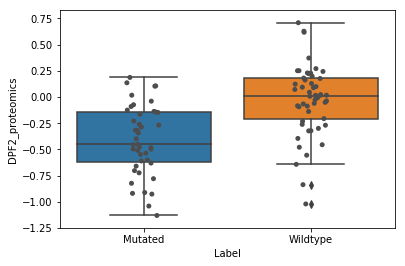

In [13]:
sns.boxplot(data = protdf, x = 'Label', y = 'DPF2_proteomics')
sns.stripplot(data = protdf, x = 'Label', y = 'DPF2_proteomics', jitter = True, dodge = True, color = '.3')

# Step 6: Use the same tools on another cancer type

Now that we have looked at endometrial cancer, we will now use the same tools on colon cancer to see if we find similar results.

In [14]:
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")

'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

No significant comparisons.


In [15]:
print("\nGene: ", gene)
    
'''Use all proteins'''
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A
Doing t-test comparisons

No significant comparisons.


Colon cancer didn't give us any significant comparison results, telling us that a mutation in ARID1A in colon cells has a different effect than a similar mutation in endometrial cells.